In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
data = xr.open_dataset('fwdP3.nc')

[None, None, None]

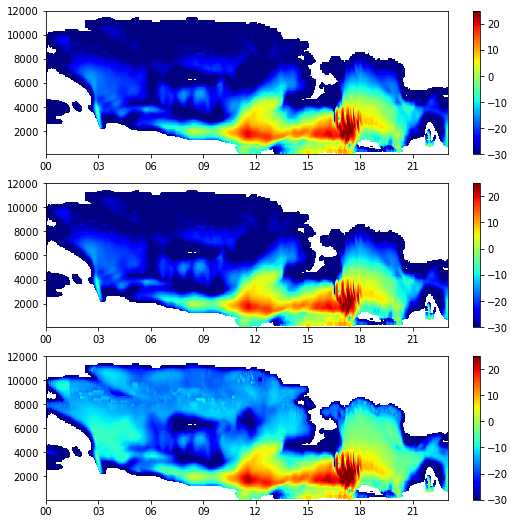

In [7]:
freq = 'X'
fig, axs = plt.subplots(3, 1, figsize=(9, 9))
mesh = axs[0].pcolormesh(data.time, data.height, data.Zssrga.loc[dict(frequency=freq)].T, vmin=-30, vmax=25, cmap='jet')
plt.colorbar(mesh, ax=axs[0])
mesh = axs[1].pcolormesh(data.time, data.height, data.Ztm.loc[dict(frequency=freq)].T, vmin=-30, vmax=25, cmap='jet')
plt.colorbar(mesh, ax=axs[1])
mesh = axs[2].pcolormesh(data.time, data.height, data.Zliu09.loc[dict(frequency=freq)].T, vmin=-30, vmax=25, cmap='jet')
plt.colorbar(mesh, ax=axs[2])
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
#fig.savefig('SSRGA_TM_Liu_'+freq_str+'.png')

[None, None]

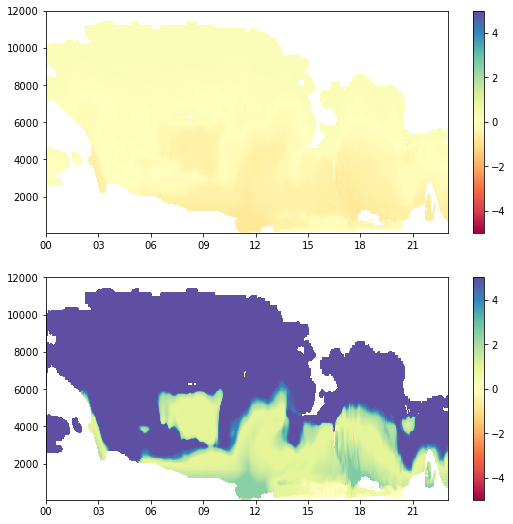

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))
freq = 'X'
mesh = axs[0].pcolormesh(data.time, data.height, data.Ztm.loc[dict(frequency=freq)].T-data.Zssrga.loc[dict(frequency=freq)].T, vmin=-5, vmax=5, cmap='Spectral')
plt.colorbar(mesh, ax=axs[0])
mesh = axs[1].pcolormesh(data.time, data.height, data.Zliu09.loc[dict(frequency=freq)].T-data.Zssrga.loc[dict(frequency=freq)].T, vmin=-5, vmax=5, cmap='Spectral')
plt.colorbar(mesh, ax=axs[1])
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
#[a.set_xlim([np.datetime64('2015-11-24T03:00'), np.datetime64('2015-11-24T04:00')]) for a in axs.flatten()]
#fig.savefig('SSRGA_TM_Liu_'+freq_str+'.png')

[None, None]

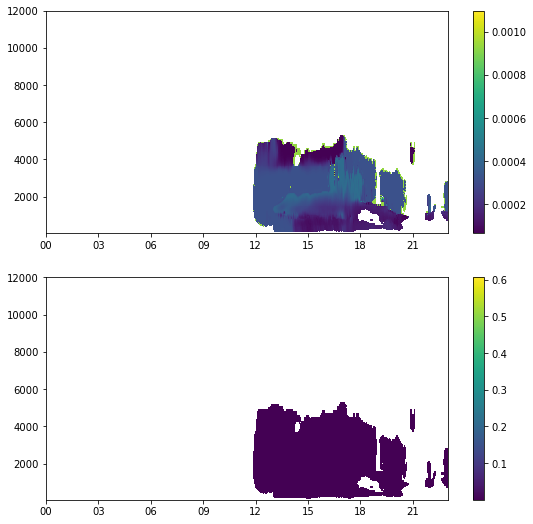

In [4]:
dcrits = data.dcrits.values
dcrits[(dcrits==0.0)+(dcrits>1)] = np.nan
dcritr = data.dcritr.values
dcritr[(dcritr==0.0)+(dcritr>1)] = np.nan
fig, axs = plt.subplots(2, 1, figsize=(9, 9))
mesh = axs[0].pcolormesh(data.time, data.height, dcrits.T)
plt.colorbar(mesh, ax=axs[0])
mesh = axs[1].pcolormesh(data.time, data.height, dcritr.T)
plt.colorbar(mesh, ax=axs[1])
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
#fig.savefig('SSRGA_TM_Liu_'+freq_str+'.png')

In [5]:
dcrits = data.dcrits.values
dcrits[(dcrits==0.0)+(dcrits>1)] = np.nan

<ipython-input-5-b93042bbdd44>:2: RuntimeWarning: invalid value encountered in greater
  dcrits[(dcrits==0.0)+(dcrits>1)] = np.nan
